In [2]:
import rasterio
from rasterio.merge import merge
import glob
import os
import geopandas as gpd
import pandas as pd
import zipfile
# Define the path to your folder
data_directory = 'data/'

# --- AUTOMATIC STEP 1 ---
# This line finds all 20 .tif files and creates a list of their paths.
tif_files = "data\cover_type_US\conus_lulc_1790.tif"

In [3]:
#zip_path = 'map_data/cb_2024_us_county_20m.zip'
#zip_path = 'map_data/tl_2010_us_county10.zip'
zip_path = 'map_data/gz_2010_us_050_00_500k.zip'
extract_dir = 'map_data/temp'

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# List files in the extracted directory to verify shapefile name
print('Extracted files:', os.listdir(extract_dir))

# Find the .shp file in the extracted directory
shp_files = [f for f in os.listdir(extract_dir) if f.endswith('.shp')]
if shp_files:
    shapefile_path = os.path.join(extract_dir, shp_files[0])
    gdf = gpd.read_file(shapefile_path)
    # Exclude Alaska (02), Hawaii (15), and Puerto Rico (72) using STATEFP column
    exclude_fips = ['02', '15', '72']
    gdf = gdf[~gdf['STATE'].isin(exclude_fips)]
    gdf['GEOID'] = gdf['GEO_ID'].str.split('US').str[1]
    
    # Sort by state code first, then by county code within each state
    gdf = gdf.sort_values(['STATE', 'COUNTY']).reset_index(drop=True)
    
    print(gdf.head(2))
else:
    print('No .shp file found in extracted directory.')

Extracted files: ['gz_2010_us_050_00_500k.dbf', 'gz_2010_us_050_00_500k.prj', 'gz_2010_us_050_00_500k.shp', 'gz_2010_us_050_00_500k.shx', 'gz_2010_us_050_00_500k.xml']
           GEO_ID STATE COUNTY     NAME    LSAD  CENSUSAREA  \
0  0500000US01001    01    001  Autauga  County     594.436   
1  0500000US01003    01    003  Baldwin  County    1589.784   

                                            geometry  GEOID  
0  POLYGON ((-86.52469 32.70706, -86.52443 32.707...  01001  
1  POLYGON ((-87.41247 30.57386, -87.41271 30.573...  01003  


In [4]:
# Extract county information into a clean DataFrame
county_df = pd.DataFrame({
    'GEOID': gdf['GEOID'],
    'STATE_CODE': gdf['STATE'], 
    'COUNTY_CODE': gdf['COUNTY'],
    'COUNTY_NAME': gdf['NAME'],
    'STATE_COUNTY_NAME': gdf['STATE'] + '_' + gdf['NAME'],
    'FULL_NAME': gdf['NAME'] + ', ' + gdf['STATE']
})
county_df = county_df.sort_values(['STATE_CODE', 'COUNTY_CODE']).reset_index(drop=True)

print(f"Created county DataFrame with {len(county_df)} counties")
print(f"Columns: {list(county_df.columns)}")
print("\nSample data:")
print(county_df.head(10))

# Optional: Save to CSV
county_df.to_csv('data/county_names.csv', index=False)
print("\nSaved county names to data/county_names.csv")

Created county DataFrame with 3109 counties
Columns: ['GEOID', 'STATE_CODE', 'COUNTY_CODE', 'COUNTY_NAME', 'STATE_COUNTY_NAME', 'FULL_NAME']

Sample data:
   GEOID STATE_CODE COUNTY_CODE COUNTY_NAME STATE_COUNTY_NAME     FULL_NAME
0  01001         01         001     Autauga        01_Autauga   Autauga, 01
1  01003         01         003     Baldwin        01_Baldwin   Baldwin, 01
2  01005         01         005     Barbour        01_Barbour   Barbour, 01
3  01007         01         007        Bibb           01_Bibb      Bibb, 01
4  01009         01         009      Blount         01_Blount    Blount, 01
5  01011         01         011     Bullock        01_Bullock   Bullock, 01
6  01013         01         013      Butler         01_Butler    Butler, 01
7  01015         01         015     Calhoun        01_Calhoun   Calhoun, 01
8  01017         01         017    Chambers       01_Chambers  Chambers, 01
9  01019         01         019    Cherokee       01_Cherokee  Cherokee, 01

Saved co

In [5]:
# --- STEP 1: Load and examine the land cover TIF file ---
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
from rasterio.enums import Resampling

# Load the land cover TIF file
print("Loading land cover data...")
with rasterio.open(tif_files) as src:
    print(f"Land cover raster info:")
    print(f"- Dimensions: {src.width} x {src.height}")
    print(f"- Bands: {src.count}")
    print(f"- CRS: {src.crs}")
    print(f"- Bounds: {src.bounds}")
    
    # Read the data with downsampling for visualization (to manage memory)
    max_dimension = max(src.width, src.height)
    if max_dimension > 3000:
        downsample_factor = max_dimension // 2000
        print(f"Downsampling by factor of {downsample_factor} for visualization")
    else:
        downsample_factor = 1
    
    target_height = src.height // downsample_factor
    target_width = src.width // downsample_factor
    
    print(f"Display size: {target_width} x {target_height}")
    
    # Read the land cover data
    cover_data = src.read(
        1, 
        out_shape=(target_height, target_width),
        resampling=Resampling.nearest  # Use nearest for categorical data
    )
    
    print(f"Data type: {cover_data.dtype}")
    print(f"Unique values: {np.unique(cover_data)}")
    print(f"Value range: {cover_data.min()} to {cover_data.max()}")
    
    # Store CRS and bounds for later use
    cover_crs = src.crs
    cover_bounds = src.bounds

Loading land cover data...
Land cover raster info:
- Dimensions: 4614 x 2907
- Bands: 1
- CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
- Bounds: BoundingBox(left=-2356113.74288345, bottom=265943.43880397454, right=2257886.25711655, top=3172943.4388039745)
Downsampling by factor of 2 for visualization
Display size: 2307 x 1453
Data type: uint8
Unique values: [0 1 2 3 4 5 6 7 8 9]
Value range: 0 to 9


In [6]:
# --- STEP 2: Reproject county boundaries to match land cover data ---
print(f"\nOriginal county boundaries CRS: {gdf.crs}")
print(f"Land cover data CRS: {cover_crs}")

# Reproject county boundaries to match land cover data CRS
if gdf.crs != cover_crs:
    gdf_reprojected = gdf.to_crs(cover_crs)
    print(f"Reprojected county boundaries CRS: {gdf_reprojected.crs}")
else:
    gdf_reprojected = gdf
    print("CRS already match - no reprojection needed")


Original county boundaries CRS: EPSG:4269
Land cover data CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Reprojected county boundaries CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"

Creating land cover visualization with county boundaries...
Adding county boundaries...
Adding colorbar...
Displaying map...


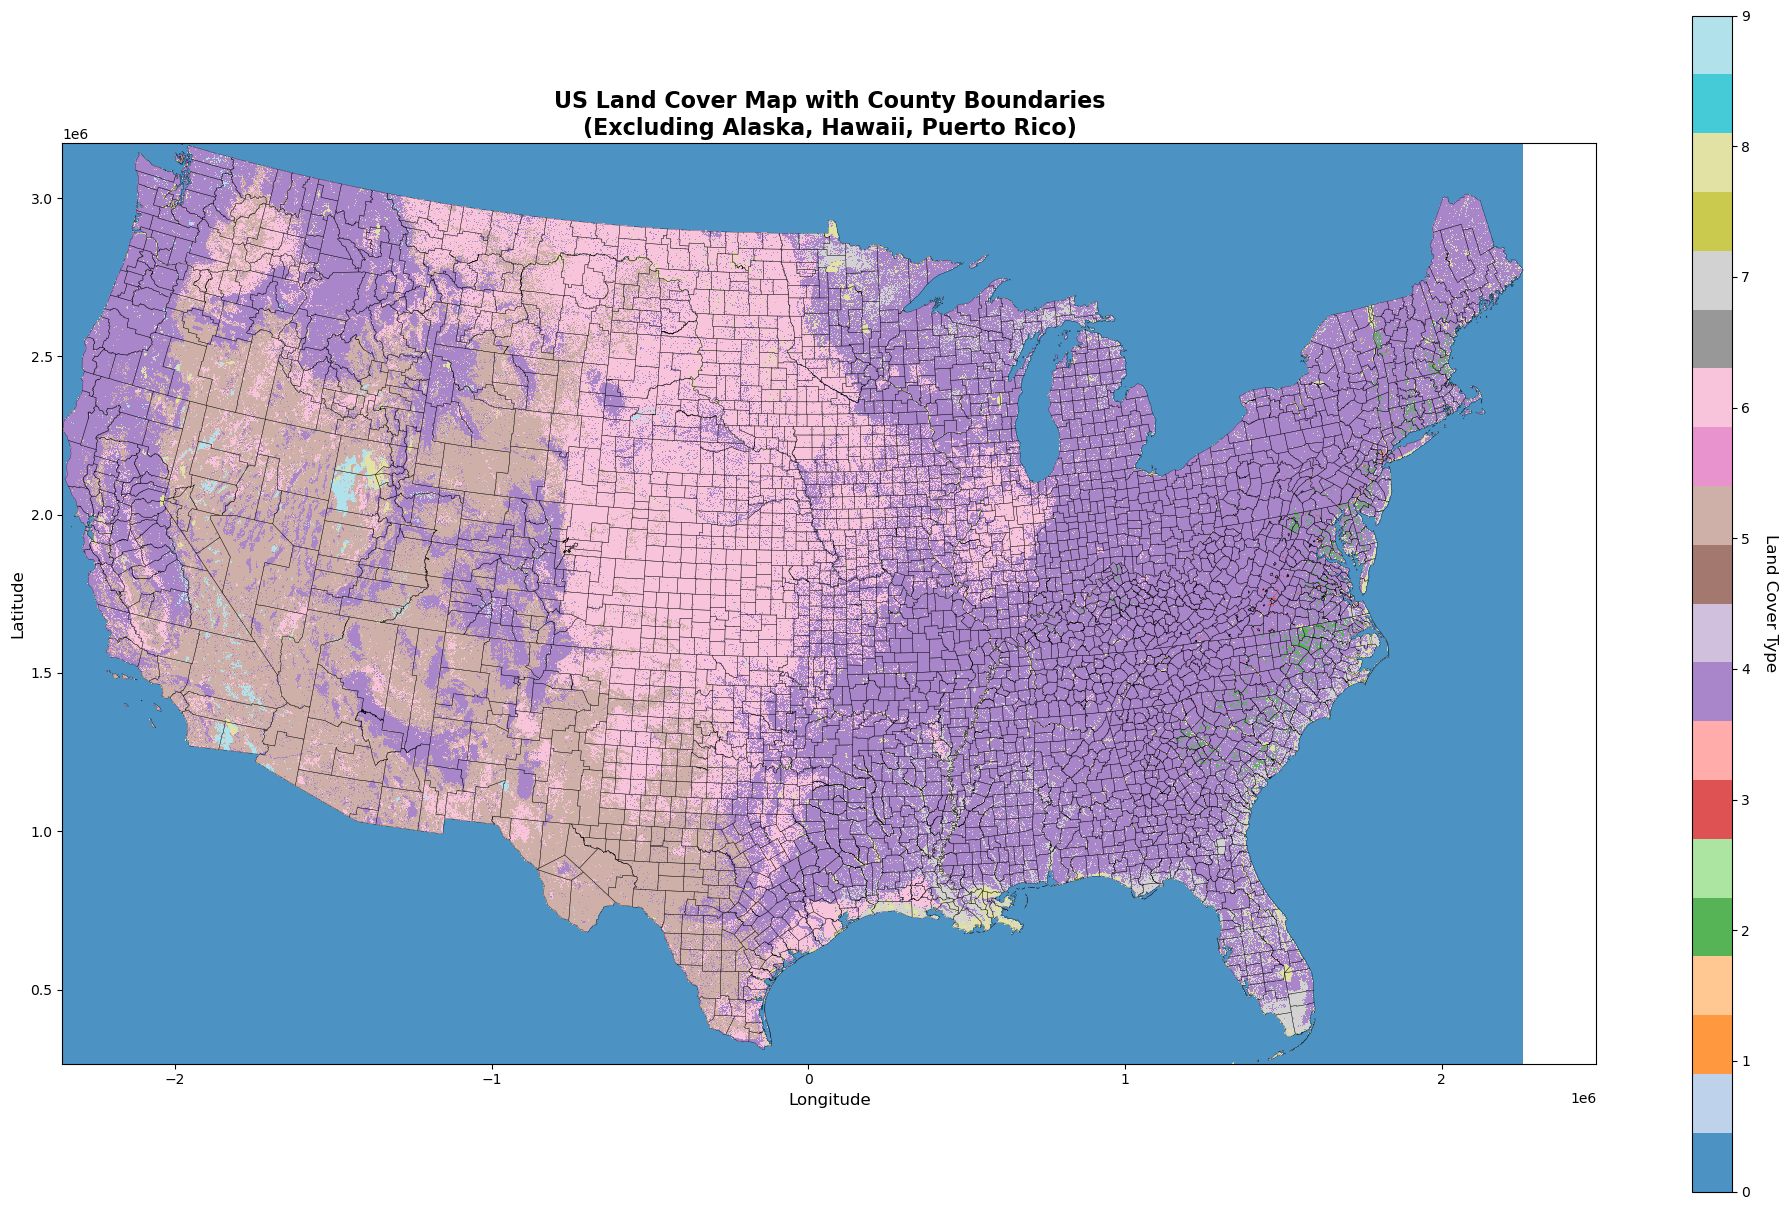


Map created with 3109 counties
Land cover types range: 0 to 9


In [7]:
# --- STEP 3: Create the main visualization ---
# Create a large figure
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

print("Creating land cover visualization with county boundaries...")

# Display the land cover raster
# Note: For land cover data, we typically use discrete color maps
im = ax.imshow(cover_data, 
               cmap='tab20',  # Good colormap for categorical data
               alpha=0.8,
               extent=[cover_bounds.left, cover_bounds.right, 
                      cover_bounds.bottom, cover_bounds.top],
               interpolation='nearest')  # Nearest neighbor for categorical data

# Overlay county boundaries
print("Adding county boundaries...")
gdf_reprojected.boundary.plot(ax=ax, linewidth=0.3, color='black', alpha=0.7)

# Set title and labels
ax.set_title('US Land Cover Map with County Boundaries\n(Excluding Alaska, Hawaii, Puerto Rico)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add a colorbar for land cover types
print("Adding colorbar...")
cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=30)
cbar.set_label('Land Cover Type', fontsize=12, rotation=270, labelpad=20)

plt.tight_layout()
print("Displaying map...")
plt.show()

print(f"\nMap created with {len(gdf_reprojected)} counties")
print(f"Land cover types range: {cover_data.min()} to {cover_data.max()}")

Creating enhanced land cover visualization...
Displaying enhanced map...


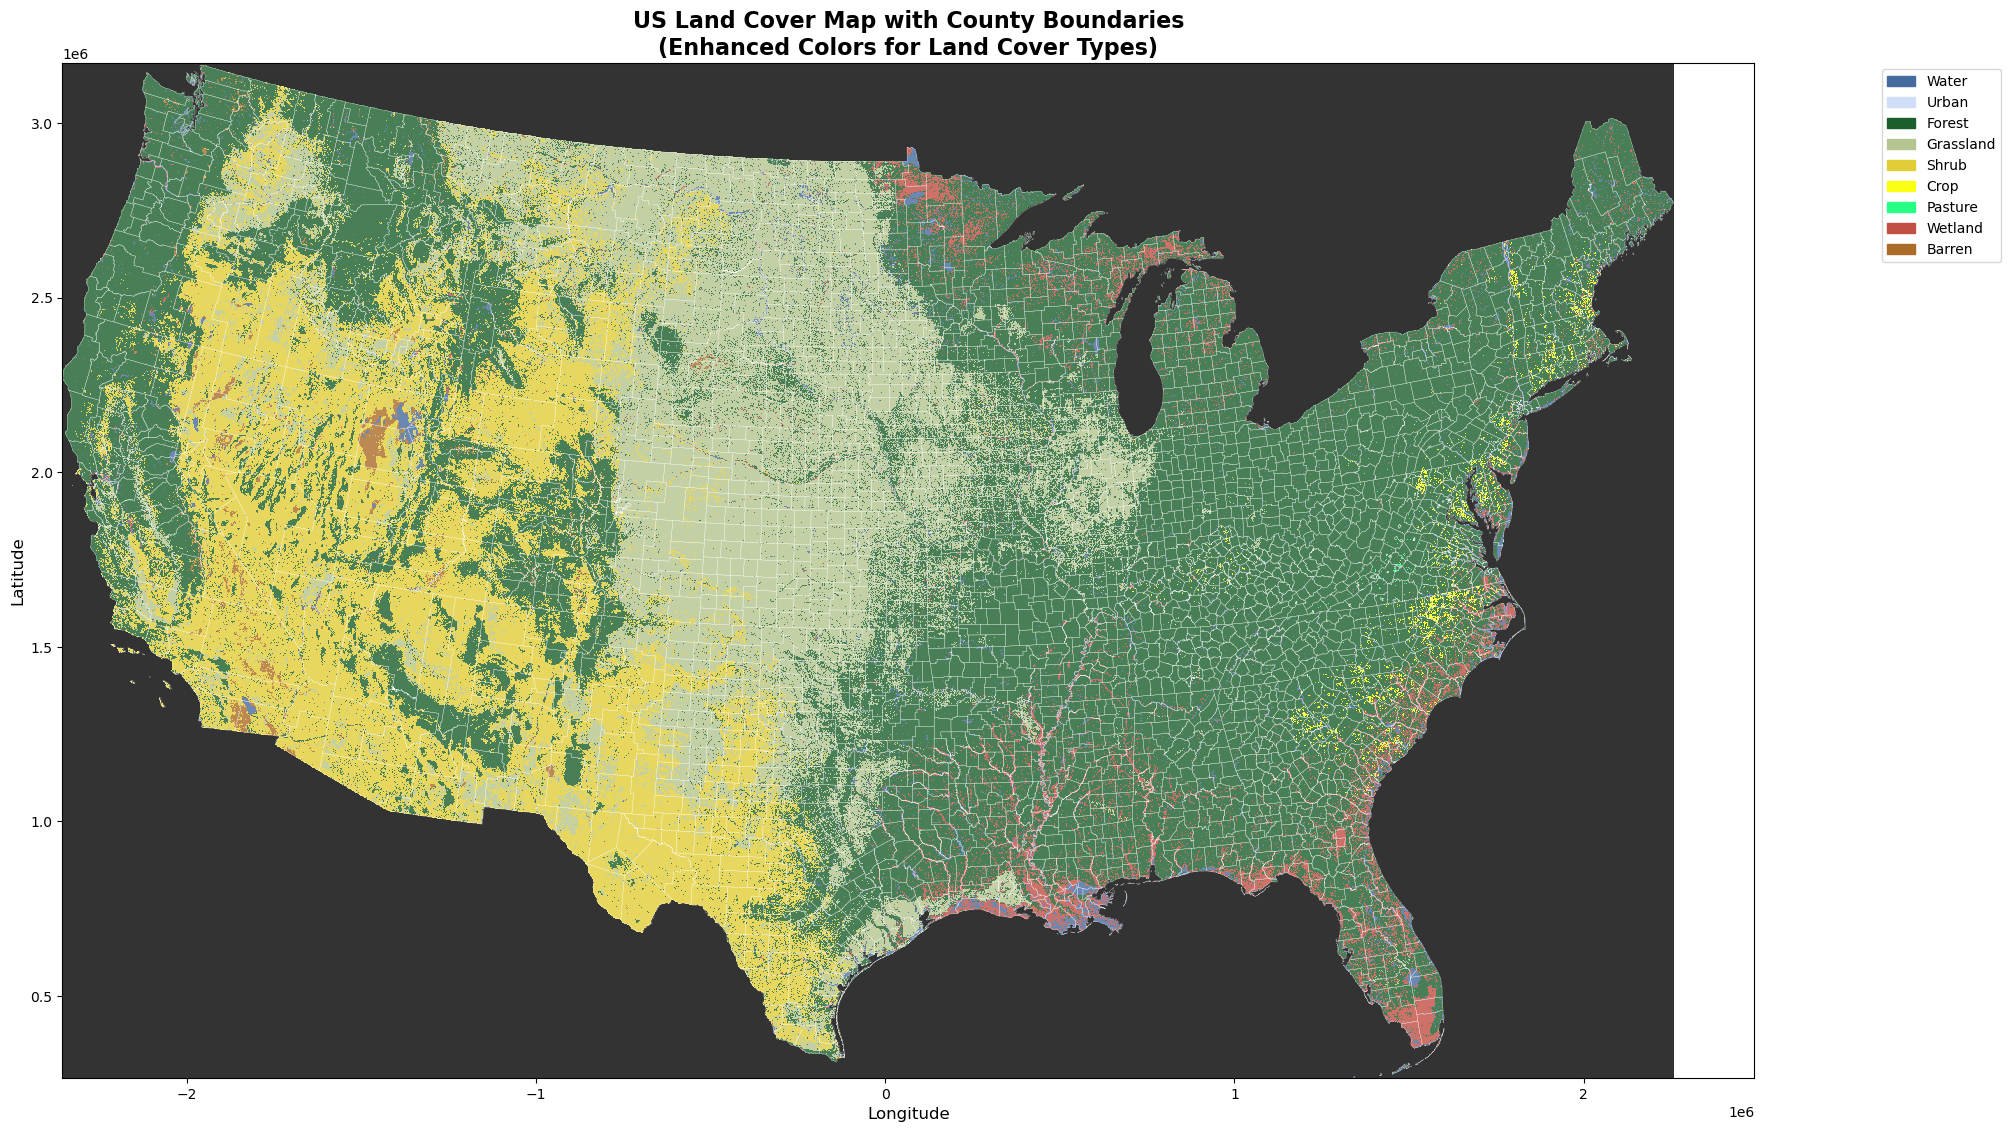

Enhanced map created with 3109 counties
Land cover categories: 10 unique types


In [8]:
# --- OPTIONAL: Enhanced visualization with custom land cover colors ---
# This creates a more interpretable map if you know what the land cover codes mean

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Create a figure with better land cover interpretation
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

print("Creating enhanced land cover visualization...")

# Updated land cover color scheme to match correct mappings
# 0=NoData, 1=Urban, 2=Crop, 3=Pasture, 4=Forest, 5=Shrub, 6=Grassland, 7=Wetland, 8=Water, 9=Barren
land_cover_colors = [
    '#000000',  # 0 - NoData/Background
    '#d1def8',  # 1 - Urban/Developed
    '#fbff13',  # 2 - Crop/Cultivated
    '#27ff87',  # 3 - Pasture/Hay
    '#1c5f2c',  # 4 - Forest
    '#e1cd36',  # 5 - Shrub/Shrubland
    '#b5c58f',  # 6 - Grassland
    '#c24f44',  # 7 - Wetland
    '#466b9f',  # 8 - Water
    '#ab6c28',  # 9 - Barren
]

# Extend the color list to cover all possible values in your data
max_value = int(cover_data.max())
while len(land_cover_colors) <= max_value:
    land_cover_colors.append('#cccccc')  # Gray for unknown categories

# Create custom colormap
custom_cmap = ListedColormap(land_cover_colors[:max_value + 1])

# Display the land cover raster with custom colors
im = ax.imshow(cover_data, 
               cmap=custom_cmap,
               alpha=0.8,
               extent=[cover_bounds.left, cover_bounds.right, 
                      cover_bounds.bottom, cover_bounds.top],
               interpolation='nearest',
               vmin=0, vmax=max_value)

# Overlay county boundaries
gdf_reprojected.boundary.plot(ax=ax, linewidth=0.2, color='white', alpha=0.9)

# Set title and labels
ax.set_title('US Land Cover Map with County Boundaries\n(Enhanced Colors for Land Cover Types)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Create a custom legend for major land cover types with corrected labels
legend_elements = [
    mpatches.Patch(color='#466b9f', label='Water'),
    mpatches.Patch(color='#d1def8', label='Urban'),
    mpatches.Patch(color='#1c5f2c', label='Forest'),
    mpatches.Patch(color='#b5c58f', label='Grassland'),
    mpatches.Patch(color='#e1cd36', label='Shrub'),
    mpatches.Patch(color='#fbff13', label='Crop'),
    mpatches.Patch(color='#27ff87', label='Pasture'),
    mpatches.Patch(color='#c24f44', label='Wetland'),
    mpatches.Patch(color='#ab6c28', label='Barren'),
]

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
print("Displaying enhanced map...")
plt.show()

print(f"Enhanced map created with {len(gdf_reprojected)} counties")
print(f"Land cover categories: {len(np.unique(cover_data))} unique types")

In [9]:
# --- Calculate County-Level Land Cover Statistics ---
from rasterstats import zonal_stats
import pandas as pd

print("Calculating land cover statistics for all counties...")

# Calculate zonal statistics for each county
stats = zonal_stats(gdf_reprojected, 
                   tif_files,
                   categorical=True,
                   geojson_out=True)

# Convert to GeoDataFrame
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(f"Completed zonal statistics for {len(stats_gdf)} counties")

Calculating land cover statistics for all counties...


c:\Users\naoki\miniforge3\envs\gnn-env\Lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Completed zonal statistics for 3109 counties


In [10]:
# --- Process Statistics into Pandas DataFrame ---

# Define land cover type labels
land_cover_labels = {
    0: 'NoData',
    1: 'Urban',
    2: 'Crop',
    3: 'Pasture',
    4: 'Forest',
    5: 'Shrub',
    6: 'Grassland',
    7: 'Wetland',
    8: 'Water',
    9: 'Barren'
}

# Extract land cover types from the statistics columns
all_cover_types = []
for col in stats_gdf.columns:
    if isinstance(col, (int, float)) or (isinstance(col, str) and col.replace('.', '', 1).isdigit()):
        try:
            cover_type = int(float(col))
            all_cover_types.append(cover_type)
        except (ValueError, TypeError):
            continue

all_cover_types = sorted(all_cover_types)

# Create pandas DataFrame with county information
county_cover_df = pd.DataFrame()

# Copy basic county information
for col in ['STATE', 'COUNTY', 'NAME', 'GEO_ID', 'GEOID']:
    if col in stats_gdf.columns:
        county_cover_df[col] = stats_gdf[col].values

# Add count columns for each land cover type using descriptive names
count_col_mapping = {}
for cover_type in all_cover_types:
    label = land_cover_labels.get(cover_type, f"Cover_Type_{cover_type}")
    count_col_name = f"{label}_count"
    count_col_mapping[cover_type] = count_col_name
    
    if cover_type in stats_gdf.columns:
        county_cover_df[count_col_name] = stats_gdf[cover_type].fillna(0).astype(int)
    else:
        county_cover_df[count_col_name] = 0

# Calculate total pixels and percentages
count_cols = list(count_col_mapping.values())
county_cover_df['total_pixels'] = county_cover_df[count_cols].sum(axis=1)

for cover_type in all_cover_types:
    label = land_cover_labels.get(cover_type, f"Cover_Type_{cover_type}")
    count_col = f"{label}_count"
    pct_col = f"{label}_pct"
    
    county_cover_df[pct_col] = np.where(
        county_cover_df['total_pixels'] > 0,
        (county_cover_df[count_col] / county_cover_df['total_pixels']) * 100,
        0
    )

print(f"Created DataFrame with {len(county_cover_df)} counties and {len(all_cover_types)} land cover types")
print(f"Land cover types: {[land_cover_labels.get(ct, f'Type_{ct}') for ct in all_cover_types]}")
print(f"\nColumns: {list(county_cover_df.columns)}")

Created DataFrame with 3109 counties and 10 land cover types
Land cover types: ['NoData', 'Urban', 'Crop', 'Pasture', 'Forest', 'Shrub', 'Grassland', 'Wetland', 'Water', 'Barren']

Columns: ['STATE', 'COUNTY', 'NAME', 'GEO_ID', 'GEOID', 'NoData_count', 'Urban_count', 'Crop_count', 'Pasture_count', 'Forest_count', 'Shrub_count', 'Grassland_count', 'Wetland_count', 'Water_count', 'Barren_count', 'total_pixels', 'NoData_pct', 'Urban_pct', 'Crop_pct', 'Pasture_pct', 'Forest_pct', 'Shrub_pct', 'Grassland_pct', 'Wetland_pct', 'Water_pct', 'Barren_pct']


In [11]:
# --- Create Clean DataFrame and Save Results ---

# The county_cover_df already has descriptive column names, so we can use it directly
# Just select the columns we want for the final output
county_cover_labeled = county_cover_df[['STATE', 'COUNTY', 'NAME', 'GEO_ID', 'GEOID', 'total_pixels']].copy()

# Add percentage columns with clean names
pct_cols = [col for col in county_cover_df.columns if col.endswith('_pct')]
for pct_col in pct_cols:
    county_cover_labeled[pct_col] = county_cover_df[pct_col]

# Save results
os.makedirs('data', exist_ok=True)
county_cover_df.to_csv('data/county_land_cover_detailed.csv', index=False)
county_cover_labeled.to_csv('data/county_land_cover_percentages.csv', index=False)

print(f"Created county-level land cover DataFrame with {county_cover_labeled.shape[0]} counties")
print(f"Percentage columns: {[col for col in county_cover_labeled.columns if col.endswith('_pct')]}")
print("Saved results to data/county_land_cover_detailed.csv and data/county_land_cover_percentages.csv")

Created county-level land cover DataFrame with 3109 counties
Percentage columns: ['NoData_pct', 'Urban_pct', 'Crop_pct', 'Pasture_pct', 'Forest_pct', 'Shrub_pct', 'Grassland_pct', 'Wetland_pct', 'Water_pct', 'Barren_pct']
Saved results to data/county_land_cover_detailed.csv and data/county_land_cover_percentages.csv


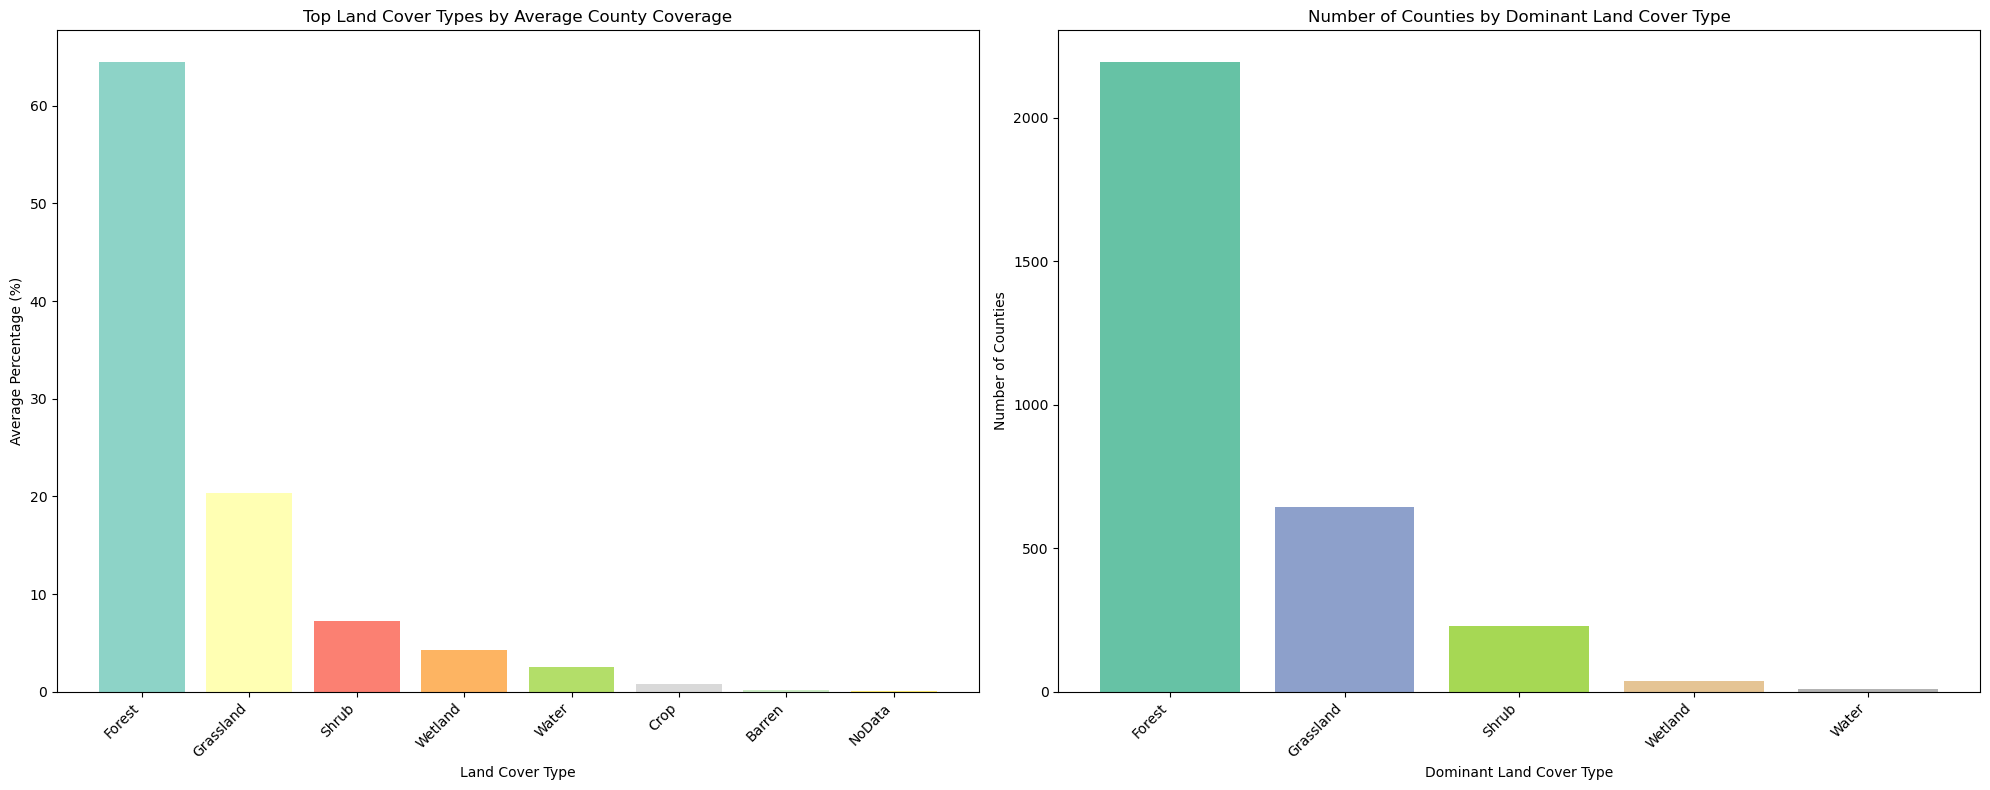

Land cover analysis complete!
Most common land cover: Forest (64.5% average)
hello
Forest_pct       64.498490
Grassland_pct    20.299035
Shrub_pct         7.281851
Wetland_pct       4.242516
Water_pct         2.549764
Crop_pct          0.792020
Barren_pct        0.144946
NoData_pct        0.081047
Urban_pct         0.063365
Pasture_pct       0.046967
dtype: float64
Most counties dominated by: Forest (2194 counties)

DataFrame columns with descriptive names:
  STATE
  COUNTY
  NAME
  GEO_ID
  GEOID
  total_pixels
  NoData_pct
  Urban_pct
  Crop_pct
  Pasture_pct
  Forest_pct
  Shrub_pct
  Grassland_pct
  Wetland_pct
  Water_pct
  Barren_pct
  dominant_cover


In [12]:
# --- Visualize Land Cover Distribution ---

# Calculate average percentages using the new descriptive column names
pct_cols = [col for col in county_cover_labeled.columns if col.endswith('_pct')]
mean_percentages = county_cover_labeled[pct_cols].mean().sort_values(ascending=False)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Top land cover types by average percentage
top_covers = mean_percentages.head(8)
bars1 = ax1.bar(range(len(top_covers)), top_covers.values, 
                color=plt.cm.Set3(np.linspace(0, 1, len(top_covers))))
ax1.set_xlabel('Land Cover Type')
ax1.set_ylabel('Average Percentage (%)')
ax1.set_title('Top Land Cover Types by Average County Coverage')
ax1.set_xticks(range(len(top_covers)))
ax1.set_xticklabels([name.replace('_pct', '').replace('_', ' ') for name in top_covers.index], 
                    rotation=45, ha='right')

# Plot 2: Dominant land cover by county count
county_cover_labeled['dominant_cover'] = county_cover_labeled[pct_cols].idxmax(axis=1)
dominant_counts = county_cover_labeled['dominant_cover'].value_counts().head(8)
bars2 = ax2.bar(range(len(dominant_counts)), dominant_counts.values,
                color=plt.cm.Set2(np.linspace(0, 1, len(dominant_counts))))
ax2.set_xlabel('Dominant Land Cover Type')
ax2.set_ylabel('Number of Counties')
ax2.set_title('Number of Counties by Dominant Land Cover Type')
ax2.set_xticks(range(len(dominant_counts)))
ax2.set_xticklabels([name.replace('_pct', '').replace('_', ' ') for name in dominant_counts.index], 
                    rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Land cover analysis complete!")
print(f"Most common land cover: {mean_percentages.index[0].replace('_pct', '').replace('_', ' ')} ({mean_percentages.iloc[0]:.1f}% average)")
print("hello")
print(mean_percentages)
print(f"Most counties dominated by: {dominant_counts.index[0].replace('_pct', '').replace('_', ' ')} ({dominant_counts.iloc[0]} counties)")

# Display the updated dataframe structure
print(f"\nDataFrame columns with descriptive names:")
for col in county_cover_labeled.columns:
    print(f"  {col}")

In [13]:
county_cover_df

,STATE,COUNTY,NAME,GEO_ID,GEOID,NoData_count,Urban_count,Crop_count,Pasture_count,Forest_count,...,NoData_pct,Urban_pct,Crop_pct,Pasture_pct,Forest_pct,Shrub_pct,Grassland_pct,Wetland_pct,Water_pct,Barren_pct
0,01,001,Autauga,0500000US01001,01001,0,0,0,0,1454,...,0.000000,0.0,0.0,0.0,92.670491,0.000000,0.000000,5.544933,1.784576,0.000000
1,01,003,Baldwin,0500000US01003,01003,8,0,0,0,3316,...,0.184162,0.0,0.0,0.0,76.335175,0.000000,0.000000,18.669429,4.811234,0.000000
2,01,005,Barbour,0500000US01005,01005,0,0,0,0,2189,...,0.000000,0.0,0.0,0.0,93.547009,0.000000,0.000000,4.358974,2.094017,0.000000
3,01,007,Bibb,0500000US01007,01007,0,0,0,0,1547,...,0.000000,0.0,0.0,0.0,95.434917,0.000000,0.000000,3.824800,0.740284,0.000000
4,01,009,Blount,0500000US01009,01009,0,0,0,0,1655,...,0.000000,0.0,0.0,0.0,98.103142,0.059277,0.355661,0.118554,1.363367,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,56,037,Sweetwater,0500000US56037,56037,0,0,0,0,828,...,0.000000,0.0,0.0,0.0,3.047703,92.476443,3.618227,0.121466,0.316549,0.419611
3105,56,039,Teton,0500000US56039,56039,0,0,0,0,9385,...,0.000000,0.0,0.0,0.0,85.927486,6.079473,1.730452,1.025453,5.072331,0.164805
3106,56,041,Uinta,0500000US56041,56041,0,0,0,0,1178,...,0.000000,0.0,0.0,0.0,21.778517,73.303753,1.774820,2.089111,0.166389,0.887410
3107,56,043,Washakie,0500000US56043,56043,0,0,0,0,821,...,0.000000,0.0,0.0,0.0,14.135675,70.506198,14.962121,0.223829,0.120523,0.051653


In [14]:
# --- PROCESS ALL YEARS FROM 1790-1900 IN 10-YEAR INCREMENTS ---
import time

def process_land_cover_for_year(year, gdf_reprojected, land_cover_labels):
    """
    Process land cover data for a specific year and return county-level statistics.
    
    Parameters:
    year (int): The year to process
    gdf_reprojected (GeoDataFrame): County boundaries reprojected to match raster CRS
    land_cover_labels (dict): Mapping of land cover codes to labels
    
    Returns:
    pandas.DataFrame: County-level land cover statistics for the specified year
    """
    print(f"Processing year {year}...")
    start_time = time.time()
    
    # Construct the file path for this year
    tif_file = f"data/cover_type_US/conus_lulc_{year}.tif"
    
    try:
        # Calculate zonal statistics for each county
        stats = zonal_stats(gdf_reprojected, 
                           tif_file,
                           categorical=True,
                           geojson_out=True)
        
        # Convert to GeoDataFrame
        stats_gdf = gpd.GeoDataFrame.from_features(stats)
        
        # Extract land cover types from the statistics columns
        all_cover_types = []
        for col in stats_gdf.columns:
            if isinstance(col, (int, float)) or (isinstance(col, str) and col.replace('.', '', 1).isdigit()):
                try:
                    cover_type = int(float(col))
                    all_cover_types.append(cover_type)
                except (ValueError, TypeError):
                    continue
        
        all_cover_types = sorted(all_cover_types)
        
        # Create pandas DataFrame with county information
        county_cover_df = pd.DataFrame()
        
        # Copy basic county information
        for col in ['STATE', 'COUNTY', 'NAME', 'GEO_ID', 'GEOID']:
            if col in stats_gdf.columns:
                county_cover_df[col] = stats_gdf[col].values
        
        # Add count columns for each land cover type using descriptive names
        count_col_mapping = {}
        for cover_type in all_cover_types:
            label = land_cover_labels.get(cover_type, f"Cover_Type_{cover_type}")
            count_col_name = f"{label}_count"
            count_col_mapping[cover_type] = count_col_name
            
            if cover_type in stats_gdf.columns:
                county_cover_df[count_col_name] = stats_gdf[cover_type].fillna(0).astype(int)
            else:
                county_cover_df[count_col_name] = 0
        
        # Calculate total pixels and percentages
        count_cols = list(count_col_mapping.values())
        county_cover_df['total_pixels'] = county_cover_df[count_cols].sum(axis=1)
        
        for cover_type in all_cover_types:
            label = land_cover_labels.get(cover_type, f"Cover_Type_{cover_type}")
            count_col = f"{label}_count"
            pct_col = f"{label}_pct"
            
            county_cover_df[pct_col] = np.where(
                county_cover_df['total_pixels'] > 0,
                (county_cover_df[count_col] / county_cover_df['total_pixels']) * 100,
                0
            )
        
        end_time = time.time()
        print(f"  Completed year {year} in {end_time - start_time:.1f} seconds")
        print(f"  Processed {len(county_cover_df)} counties with {len(all_cover_types)} land cover types")
        
        return county_cover_df
        
    except Exception as e:
        print(f"  Error processing year {year}: {str(e)}")
        return None

# Define the years to process (1790-2020 in 10-year increments)
target_years = list(range(1790, 2021, 10))  # [1790, 1800, 1810, ..., 2020]
print(f"Target years: {target_years}")

# Initialize dictionary to store all datasets
county_cover_datasets = {}

# Define land cover type labels (same as before)
land_cover_labels = {
    0: 'NoData',
    1: 'Urban', 
    2: 'Crop',
    3: 'Pasture',
    4: 'Forest',
    5: 'Shrub',
    6: 'Grassland',
    7: 'Wetland',
    8: 'Water',
    9: 'Barren'
}

print(f"\nStarting processing of {len(target_years)} years...")
print("="*60)

# Process each year
total_start_time = time.time()
for year in target_years:
    county_df_year = process_land_cover_for_year(year, gdf_reprojected, land_cover_labels)
    
    if county_df_year is not None:
        county_cover_datasets[year] = county_df_year
        print(f"  ✓ Successfully stored data for year {year}")
    else:
        print(f"  ✗ Failed to process year {year}")
    print()

total_end_time = time.time()
print("="*60)
print(f"Processing complete! Total time: {total_end_time - total_start_time:.1f} seconds")
print(f"Successfully processed {len(county_cover_datasets)} out of {len(target_years)} years")
print(f"Years in dataset: {sorted(county_cover_datasets.keys())}")

# Display summary information
if county_cover_datasets:
    sample_year = min(county_cover_datasets.keys())
    sample_df = county_cover_datasets[sample_year]
    print(f"\nSample dataset structure (year {sample_year}):")
    print(f"  Shape: {sample_df.shape}")
    print(f"  Columns: {len(sample_df.columns)}")
    
    # Show percentage columns
    pct_cols = [col for col in sample_df.columns if col.endswith('_pct')]
    print(f"  Land cover percentage columns: {len(pct_cols)}")
    for col in pct_cols:
        print(f"    - {col}")

Target years: [1790, 1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]

Starting processing of 24 years...
Processing year 1790...


KeyboardInterrupt: 

In [15]:
# --- PROCESS ALL YEARS FROM 1790-1900 IN 10-YEAR INCREMENTS ---
import time
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterstats import zonal_stats

def process_land_cover_for_year(year, gdf_reprojected, land_cover_labels):
    """
    Process land cover data for a specific year and return county-level statistics
    as both a pandas DataFrame and a GeoPandas GeoDataFrame.
    
    Parameters:
    year (int): The year to process
    gdf_reprojected (GeoDataFrame): County boundaries reprojected to match raster CRS
    land_cover_labels (dict): Mapping of land cover codes to labels
    
    Returns:
    tuple: A tuple containing (pandas.DataFrame, geopandas.GeoDataFrame) for the 
           specified year, or None if an error occurs.
    """
    print(f"Processing year {year}...")
    start_time = time.time()
    
    # Construct the file path for this year
    tif_file = f"data/cover_type_US/conus_lulc_{year}.tif"
    
    try:
        # Calculate zonal statistics for each county
        stats = zonal_stats(gdf_reprojected, 
                            tif_file,
                            categorical=True,
                            geojson_out=True)
        
        # Convert to GeoDataFrame
        stats_gdf = gpd.GeoDataFrame.from_features(stats)
        
        # --- Data Processing and Column Naming ---
        
        # Extract land cover types from the statistics columns (which are numeric)
        all_cover_types = []
        for col in stats_gdf.columns:
            if isinstance(col, (int, float)) or (isinstance(col, str) and col.replace('.', '', 1).isdigit()):
                try:
                    cover_type = int(float(col))
                    all_cover_types.append(cover_type)
                except (ValueError, TypeError):
                    continue
        
        all_cover_types = sorted(list(set(all_cover_types)))
        
        # Create a mapping from numeric code to new descriptive column name
        rename_mapping = {}
        for cover_type in all_cover_types:
            label = land_cover_labels.get(cover_type, f"Cover_Type_{cover_type}")
            rename_mapping[cover_type] = f"{label}_count"
            
        # Rename the numeric columns to descriptive names
        stats_gdf.rename(columns=rename_mapping, inplace=True)
        
        # Get the list of new count columns and fill any missing values with 0
        count_cols = list(rename_mapping.values())
        for col in count_cols:
            if col not in stats_gdf.columns:
                stats_gdf[col] = 0 # Add column if it doesn't exist for this year
        stats_gdf[count_cols] = stats_gdf[count_cols].fillna(0).astype(int)
        
        # --- Calculate total pixels and percentages ---
        
        stats_gdf['total_pixels'] = stats_gdf[count_cols].sum(axis=1)
        
        for count_col in count_cols:
            pct_col = count_col.replace('_count', '_pct')
            stats_gdf[pct_col] = np.where(
                stats_gdf['total_pixels'] > 0,
                (stats_gdf[count_col] / stats_gdf['total_pixels']) * 100,
                0
            )
            
        # --- Finalize and return both DataFrame and GeoDataFrame ---
        
        # This is our final GeoDataFrame with geometry
        final_gdf = stats_gdf
        
        # Create the standard pandas DataFrame by dropping the geometry column
        final_df = pd.DataFrame(final_gdf.drop(columns='geometry'))

        end_time = time.time()
        print(f"  Completed year {year} in {end_time - start_time:.1f} seconds")
        print(f"  Processed {len(final_gdf)} counties with {len(all_cover_types)} land cover types")
        
        return final_df, final_gdf
        
    except Exception as e:
        print(f"  Error processing year {year}: {str(e)}")
        return None

# Define the years to process (1790-2020 in 10-year increments)
# Note: The user comment specifies 1790-1900, but the code uses up to 2020.
# We will use the range from the original code.
target_years = list(range(1790, 1901, 10))  # [1790, 1800, 1810, ..., 2020]
print(f"Target years: {target_years}")

# Initialize dictionaries to store all datasets
county_cover_datasets = {}      # To store pandas DataFrames
county_cover_geodatasets = {}   # To store GeoPandas GeoDataFrames

# Define land cover type labels (same as before)
land_cover_labels = {
    0: 'NoData',
    1: 'Urban', 
    2: 'Crop',
    3: 'Pasture',
    4: 'Forest',
    5: 'Shrub',
    6: 'Grassland',
    7: 'Wetland',
    8: 'Water',
    9: 'Barren'
}

print(f"\nStarting processing of {len(target_years)} years...")
print("="*60)

# Process each year
total_start_time = time.time()
for year in target_years:
    # The function now returns a tuple of two dataframes
    results = process_land_cover_for_year(year, gdf_reprojected, land_cover_labels)
    
    if results is not None:
        county_df_year, county_gdf_year = results
        county_cover_datasets[year] = county_df_year
        county_cover_geodatasets[year] = county_gdf_year
        print(f"  ✓ Successfully stored DataFrame and GeoDataFrame for year {year}")
    else:
        print(f"  ✗ Failed to process year {year}")
    print()

total_end_time = time.time()
print("="*60)
print(f"Processing complete! Total time: {total_end_time - total_start_time:.1f} seconds")
print(f"Successfully processed {len(county_cover_datasets)} out of {len(target_years)} years")
print(f"Years in dataset: {sorted(county_cover_datasets.keys())}")

# Display summary information
if county_cover_datasets:
    sample_year = min(county_cover_datasets.keys())
    sample_df = county_cover_datasets[sample_year]
    sample_gdf = county_cover_geodatasets[sample_year]
    
    print(f"\nSample pandas DataFrame structure (year {sample_year}):")
    print(f"  Shape: {sample_df.shape}")
    print(f"  Columns: {len(sample_df.columns)}")
    
    print(f"\nSample GeoDataFrame structure (year {sample_year}):")
    print(f"  Shape: {sample_gdf.shape}")
    print(f"  CRS: {sample_gdf.crs}")

    # Show percentage columns from one of the dataframes
    pct_cols = [col for col in sample_df.columns if col.endswith('_pct')]
    print(f"  Land cover percentage columns: {len(pct_cols)}")
    for col in sorted(pct_cols):
        print(f"    - {col}")

Target years: [1790, 1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900]

Starting processing of 12 years...
Processing year 1790...
  Completed year 1790 in 12.1 seconds
  Processed 3109 counties with 10 land cover types
  ✓ Successfully stored DataFrame and GeoDataFrame for year 1790

Processing year 1800...
  Completed year 1800 in 12.5 seconds
  Processed 3109 counties with 10 land cover types
  ✓ Successfully stored DataFrame and GeoDataFrame for year 1800

Processing year 1810...
  Completed year 1810 in 12.4 seconds
  Processed 3109 counties with 10 land cover types
  ✓ Successfully stored DataFrame and GeoDataFrame for year 1810

Processing year 1820...
  Completed year 1820 in 12.3 seconds
  Processed 3109 counties with 10 land cover types
  ✓ Successfully stored DataFrame and GeoDataFrame for year 1820

Processing year 1830...
  Completed year 1830 in 12.2 seconds
  Processed 3109 counties with 10 land cover types
  ✓ Successfully stored DataFrame and GeoDataFra

In [16]:
# --- ANALYZE THE MULTI-YEAR LAND COVER DATASETS ---

print("="*70)
print("MULTI-YEAR LAND COVER ANALYSIS SUMMARY")
print("="*70)

# Display basic information about all datasets
print(f"\n1. DATASET OVERVIEW:")
print(f"   • Total years processed: {len(county_cover_datasets)}")
print(f"   • Years available: {sorted(county_cover_datasets.keys())}")
print(f"   • Time span: {min(county_cover_datasets.keys())}-{max(county_cover_datasets.keys())}")

# Check consistency across years
if county_cover_datasets:
    first_year = min(county_cover_datasets.keys())
    first_df = county_cover_datasets[first_year]
    
    print(f"\n2. DATASET STRUCTURE (consistent across all years):")
    print(f"   • Counties per year: {len(first_df)}")
    print(f"   • Total columns per dataset: {len(first_df.columns)}")
    
    # Identify column types
    pct_cols = [col for col in first_df.columns if col.endswith('_pct')]
    count_cols = [col for col in first_df.columns if col.endswith('_count')]
    info_cols = [col for col in first_df.columns if not (col.endswith('_pct') or col.endswith('_count') or col == 'total_pixels')]
    
    print(f"   • Information columns: {len(info_cols)} {info_cols}")
    print(f"   • Land cover count columns: {len(count_cols)}")
    print(f"   • Land cover percentage columns: {len(pct_cols)}")
    
    print(f"\n3. LAND COVER TYPES TRACKED:")
    land_cover_types = [col.replace('_pct', '') for col in pct_cols]
    for i, lc_type in enumerate(land_cover_types, 1):
        print(f"   {i:2d}. {lc_type}")

# Create a summary showing how land cover changes over time
print(f"\n4. TEMPORAL ANALYSIS - Average Land Cover by Decade:")
print("   " + "-"*60)

if len(county_cover_datasets) > 1:
    # Calculate average percentages for each year
    yearly_averages = pd.DataFrame()
    
    for year in sorted(county_cover_datasets.keys()):
        df = county_cover_datasets[year]
        pct_cols = [col for col in df.columns if col.endswith('_pct')]
        
        year_avg = df[pct_cols].mean()
        year_avg.name = year
        yearly_averages = pd.concat([yearly_averages, year_avg], axis=1)
    
    # Transpose so years are rows
    yearly_averages = yearly_averages.T
    
    # Show top 5 land cover types for display
    first_year_avg = yearly_averages.iloc[0]
    top_5_covers = first_year_avg.nlargest(5).index
    
    print(f"   Top 5 Land Cover Types (% of total area):")
    print(f"   {'Year':<6}", end='')
    for cover in top_5_covers:
        clean_name = cover.replace('_pct', '').replace('_', ' ')[:10]
        print(f"{clean_name:>10}", end='')
    print()
    print("   " + "-"*60)
    
    for year in yearly_averages.index:
        print(f"   {year:<6}", end='')
        for cover in top_5_covers:
            print(f"{yearly_averages.loc[year, cover]:10.1f}", end='')
        print()

# Show some interesting statistics
print(f"\n5. DATASET STATISTICS:")
total_counties = len(first_df) if county_cover_datasets else 0
total_datapoints = len(county_cover_datasets) * total_counties
print(f"   • Total county-year observations: {total_datapoints:,}")
print(f"   • Total data values (all columns): {total_datapoints * len(first_df.columns) if county_cover_datasets else 0:,}")

# Memory usage estimate
if county_cover_datasets:
    memory_mb = sum(df.memory_usage(deep=True).sum() for df in county_cover_datasets.values()) / (1024*1024)
    print(f"   • Estimated memory usage: {memory_mb:.1f} MB")

print(f"\n6. ACCESS EXAMPLES:")
print(f"   • Access 1790 data: county_cover_datasets[1790]")
print(f"   • Access 1920 data: county_cover_datasets[1920]") 
print(f"   • Access 2020 data: county_cover_datasets[2020]")
print(f"   • List all years: list(county_cover_datasets.keys())")
print(f"   • Get forest % for 1800: county_cover_datasets[1800]['Forest_pct']")

print("\n" + "="*70)
print("PROCESSING COMPLETE - All datasets ready for analysis!")
print("="*70)

MULTI-YEAR LAND COVER ANALYSIS SUMMARY

1. DATASET OVERVIEW:
   • Total years processed: 12
   • Years available: [1790, 1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900]
   • Time span: 1790-1900

2. DATASET STRUCTURE (consistent across all years):
   • Counties per year: 3109
   • Total columns per dataset: 28
   • Information columns: 7 ['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'GEOID']
   • Land cover count columns: 10
   • Land cover percentage columns: 10

3. LAND COVER TYPES TRACKED:
    1. NoData
    2. Urban
    3. Crop
    4. Pasture
    5. Forest
    6. Shrub
    7. Grassland
    8. Wetland
    9. Water
   10. Barren

4. TEMPORAL ANALYSIS - Average Land Cover by Decade:
   ------------------------------------------------------------
   Top 5 Land Cover Types (% of total area):
   Year      Forest Grassland     Shrub   Wetland     Water
   ------------------------------------------------------------
   1790        64.5      20.3       7.3    

In [17]:
county_cover_geodatasets[1790]

,geometry,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,Forest_count,Wetland_count,...,NoData_pct,Urban_pct,Crop_pct,Pasture_pct,Forest_pct,Shrub_pct,Grassland_pct,Wetland_pct,Water_pct,Barren_pct
0,"POLYGON ((881759.199 1114602.53, 881783.211 11...",0500000US01001,01,001,Autauga,County,594.436,01001,1454,87,...,0.000000,0.0,0.0,0.0,92.670491,0.000000,0.000000,5.544933,1.784576,0.000000
1,"POLYGON ((820813.582 870207.64, 820796.977 870...",0500000US01003,01,003,Baldwin,County,1589.784,01003,3316,811,...,0.184162,0.0,0.0,0.0,76.335175,0.000000,0.000000,18.669429,4.811234,0.000000
2,"POLYGON ((1022285.197 1028056.448, 1022305.898...",0500000US01005,01,005,Barbour,County,884.876,01005,2189,102,...,0.000000,0.0,0.0,0.0,93.547009,0.000000,0.000000,4.358974,2.094017,0.000000
3,"POLYGON ((825530.89 1123561.709, 821922.415 11...",0500000US01007,01,007,Bibb,County,622.582,01007,1547,62,...,0.000000,0.0,0.0,0.0,95.434917,0.000000,0.000000,3.824800,0.740284,0.000000
4,"POLYGON ((848383.878 1258023.836, 848735.502 1...",0500000US01009,01,009,Blount,County,644.776,01009,1655,2,...,0.000000,0.0,0.0,0.0,98.103142,0.059277,0.355661,0.118554,1.363367,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,"POLYGON ((-1085521.057 2073715.214, -1095733.8...",0500000US56037,56,037,Sweetwater,County,10426.649,56037,828,33,...,0.000000,0.0,0.0,0.0,3.047703,92.476443,3.618227,0.121466,0.316549,0.419611
3105,"POLYGON ((-1200815.828 2408199.842, -1200685.7...",0500000US56039,56,039,Teton,County,3995.379,56039,9385,112,...,0.000000,0.0,0.0,0.0,85.927486,6.079473,1.730452,1.025453,5.072331,0.164805
3106,"POLYGON ((-1167348.582 2089921.069, -1168036.0...",0500000US56041,56,041,Uinta,County,2081.264,56041,1178,113,...,0.000000,0.0,0.0,0.0,21.778517,73.303753,1.774820,2.089111,0.166389,0.887410
3107,"POLYGON ((-887412.186 2385732.421, -888096.316...",0500000US56043,56,043,Washakie,County,2238.549,56043,821,13,...,0.000000,0.0,0.0,0.0,14.135675,70.506198,14.962121,0.223829,0.120523,0.051653


Creating comprehensive temporal land cover change visualizations...
Created yearly averages DataFrame with shape: (12, 10)
Years: [1790, 1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900]
Land cover types: ['NoData', 'Urban', 'Crop', 'Pasture', 'Forest', 'Shrub', 'Grassland', 'Wetland', 'Water', 'Barren']


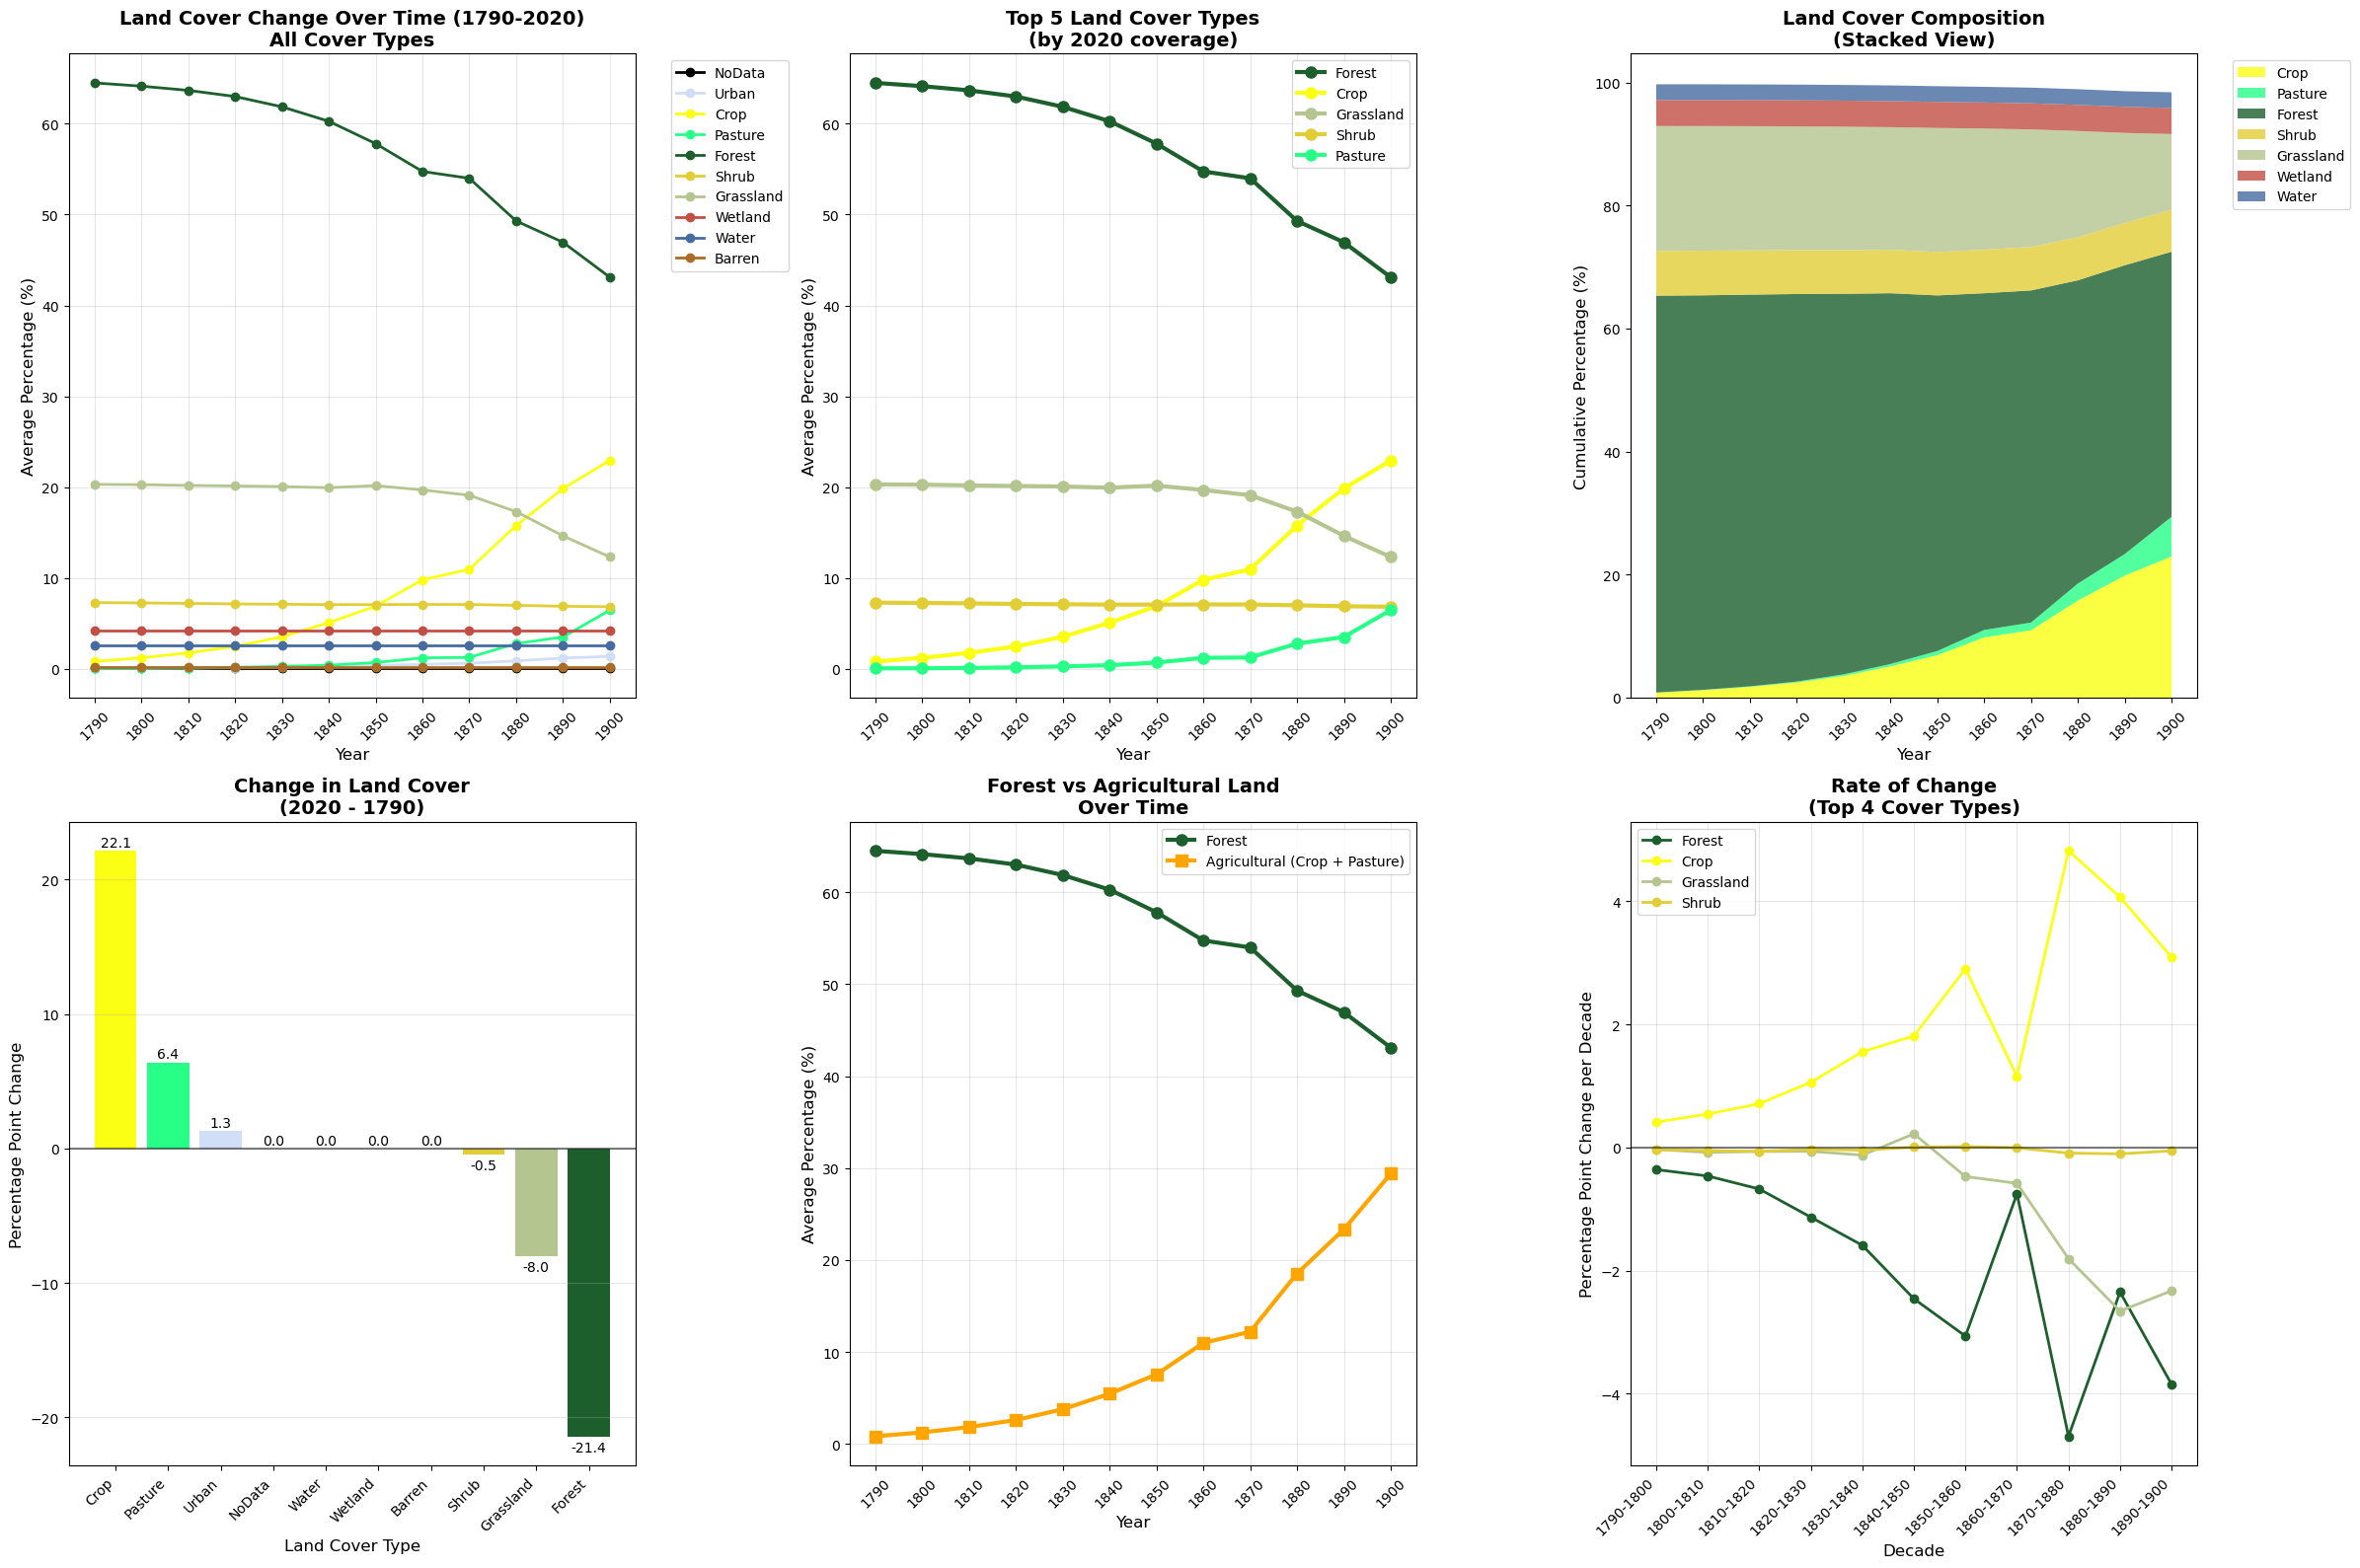


LAND COVER CHANGE SUMMARY (1790-2020)

LARGEST INCREASES (percentage points):
  Crop        : + 22.1 percentage points
  Pasture     : +  6.4 percentage points
  Urban       : +  1.3 percentage points

LARGEST DECREASES (percentage points):
  Forest      : -21.4 percentage points
  Grassland   :  -8.0 percentage points
  Shrub       :  -0.5 percentage points

LAND COVER IN 1790 vs 2020 (top 5 each year):
1790 (top 5):
  Forest      :  64.5%
  Grassland   :  20.3%
  Shrub       :   7.3%
  Wetland     :   4.2%
  Water       :   2.5%
2020 (top 5):
  Forest      :  43.1%
  Crop        :  22.9%
  Grassland   :  12.3%
  Shrub       :   6.8%
  Pasture     :   6.5%



In [20]:
# --- TEMPORAL LAND COVER CHANGE VISUALIZATIONS ---
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

print("Creating comprehensive temporal land cover change visualizations...")

# First, create the yearly averages DataFrame
yearly_averages = pd.DataFrame()

for year in sorted(county_cover_datasets.keys()):
    df = county_cover_datasets[year]
    pct_cols = [col for col in df.columns if col.endswith('_pct')]
    
    year_avg = df[pct_cols].mean()
    year_avg.name = year
    yearly_averages = pd.concat([yearly_averages, year_avg], axis=1)

# Transpose so years are rows and land cover types are columns
yearly_averages = yearly_averages.T

# Clean up column names for better display
yearly_averages.columns = [col.replace('_pct', '') for col in yearly_averages.columns]

print(f"Created yearly averages DataFrame with shape: {yearly_averages.shape}")
print(f"Years: {list(yearly_averages.index)}")
print(f"Land cover types: {list(yearly_averages.columns)}")

# Define colors for each land cover type (matching our earlier color scheme)
land_cover_color_map = {
    'NoData': '#000000',
    'Urban': '#d1def8', 
    'Crop': '#fbff13',
    'Pasture': '#27ff87',
    'Forest': '#1c5f2c',
    'Shrub': '#e1cd36',
    'Grassland': '#b5c58f',
    'Wetland': '#c24f44',
    'Water': '#466b9f',
    'Barren': '#ab6c28'
}

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(24, 16))

# 1. Overall trend lines for all land cover types
ax1 = plt.subplot(2, 3, 1)
for cover_type in yearly_averages.columns:
    if cover_type in land_cover_color_map:
        color = land_cover_color_map[cover_type]
        plt.plot(yearly_averages.index, yearly_averages[cover_type], 
                marker='o', linewidth=2, markersize=6, color=color, label=cover_type)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Percentage (%)', fontsize=12)
plt.title('Land Cover Change Over Time (1790-2020)\nAll Cover Types', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(yearly_averages.index, rotation=45)

# 2. Top 5 land cover types (larger view)
ax2 = plt.subplot(2, 3, 2)
top_5_covers = yearly_averages.iloc[-1].nlargest(5).index  # Top 5 in 1900
for cover_type in top_5_covers:
    if cover_type in land_cover_color_map:
        color = land_cover_color_map[cover_type]
        plt.plot(yearly_averages.index, yearly_averages[cover_type], 
                marker='o', linewidth=3, markersize=8, color=color, label=cover_type)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Percentage (%)', fontsize=12)
plt.title('Top 5 Land Cover Types\n(by 2020 coverage)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(yearly_averages.index, rotation=45)

# 3. Stacked area chart showing composition over time
ax3 = plt.subplot(2, 3, 3)
# Select major cover types for stacking (exclude NoData and very small categories)
major_covers = yearly_averages.columns[yearly_averages.iloc[-1] > 2.0]  # Types with >2% in 2020
colors_list = [land_cover_color_map.get(cover, '#cccccc') for cover in major_covers]

plt.stackplot(yearly_averages.index, 
              *[yearly_averages[cover] for cover in major_covers],
              labels=major_covers, colors=colors_list, alpha=0.8)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Percentage (%)', fontsize=12)
plt.title('Land Cover Composition\n(Stacked View)', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(yearly_averages.index, rotation=45)

# 4. Change from 1790 to 2020 (bar chart)
ax4 = plt.subplot(2, 3, 4)
change_1790_to_2020 = yearly_averages.loc[1900] - yearly_averages.loc[1790]
change_1790_to_2020 = change_1790_to_2020.sort_values(ascending=False)

colors_bar = [land_cover_color_map.get(cover, '#cccccc') for cover in change_1790_to_2020.index]
bars = plt.bar(range(len(change_1790_to_2020)), change_1790_to_2020.values, color=colors_bar)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Land Cover Type', fontsize=12)
plt.ylabel('Percentage Point Change', fontsize=12)
plt.title('Change in Land Cover\n(2020 - 1790)', fontsize=14, fontweight='bold')
plt.xticks(range(len(change_1790_to_2020)), change_1790_to_2020.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, change_1790_to_2020.values)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height >= 0 else -0.3),
             f'{value:.1f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

# 5. Forest vs Agricultural land over time
ax5 = plt.subplot(2, 3, 5)
agricultural_covers = ['Crop', 'Pasture']
forest_cover = 'Forest'

# Calculate agricultural total
agri_total = yearly_averages[agricultural_covers].sum(axis=1)

plt.plot(yearly_averages.index, yearly_averages[forest_cover], 
         marker='o', linewidth=3, markersize=8, color=land_cover_color_map[forest_cover], 
         label='Forest')
plt.plot(yearly_averages.index, agri_total, 
         marker='s', linewidth=3, markersize=8, color='orange', 
         label='Agricultural (Crop + Pasture)')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Percentage (%)', fontsize=12)
plt.title('Forest vs Agricultural Land\nOver Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(yearly_averages.index, rotation=45)

# 6. Rate of change (decade-over-decade)
ax6 = plt.subplot(2, 3, 6)
# Calculate 10-year changes for top 4 cover types
top_4_covers = yearly_averages.iloc[-1].nlargest(4).index
decade_changes = pd.DataFrame()

for i in range(1, len(yearly_averages)):
    year = yearly_averages.index[i]
    prev_year = yearly_averages.index[i-1]
    change = yearly_averages.iloc[i] - yearly_averages.iloc[i-1]
    change.name = f"{prev_year}-{year}"
    decade_changes = pd.concat([decade_changes, change], axis=1)

decade_changes = decade_changes.T

for cover_type in top_4_covers:
    if cover_type in land_cover_color_map:
        color = land_cover_color_map[cover_type]
        plt.plot(range(len(decade_changes)), decade_changes[cover_type], 
                marker='o', linewidth=2, markersize=6, color=color, label=cover_type)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Percentage Point Change per Decade', fontsize=12)
plt.title('Rate of Change\n(Top 4 Cover Types)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(len(decade_changes)), decade_changes.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("LAND COVER CHANGE SUMMARY (1790-2020)")
print("="*80)

print(f"\nLARGEST INCREASES (percentage points):")
increases = change_1790_to_2020[change_1790_to_2020 > 0].sort_values(ascending=False)
for cover, change in increases.head(5).items():
    print(f"  {cover:12s}: +{change:5.1f} percentage points")

print(f"\nLARGEST DECREASES (percentage points):")
decreases = change_1790_to_2020[change_1790_to_2020 < 0].sort_values()
for cover, change in decreases.head(5).items():
    print(f"  {cover:12s}: {change:5.1f} percentage points")

print(f"\nLAND COVER IN 1790 vs 2020 (top 5 each year):")
print("1790 (top 5):")
for cover, pct in yearly_averages.loc[1790].nlargest(5).items():
    print(f"  {cover:12s}: {pct:5.1f}%")

print("2020 (top 5):")
for cover, pct in yearly_averages.loc[1900].nlargest(5).items():
    print(f"  {cover:12s}: {pct:5.1f}%")

print("\n" + "="*80)

Creating additional temporal analysis visualizations...


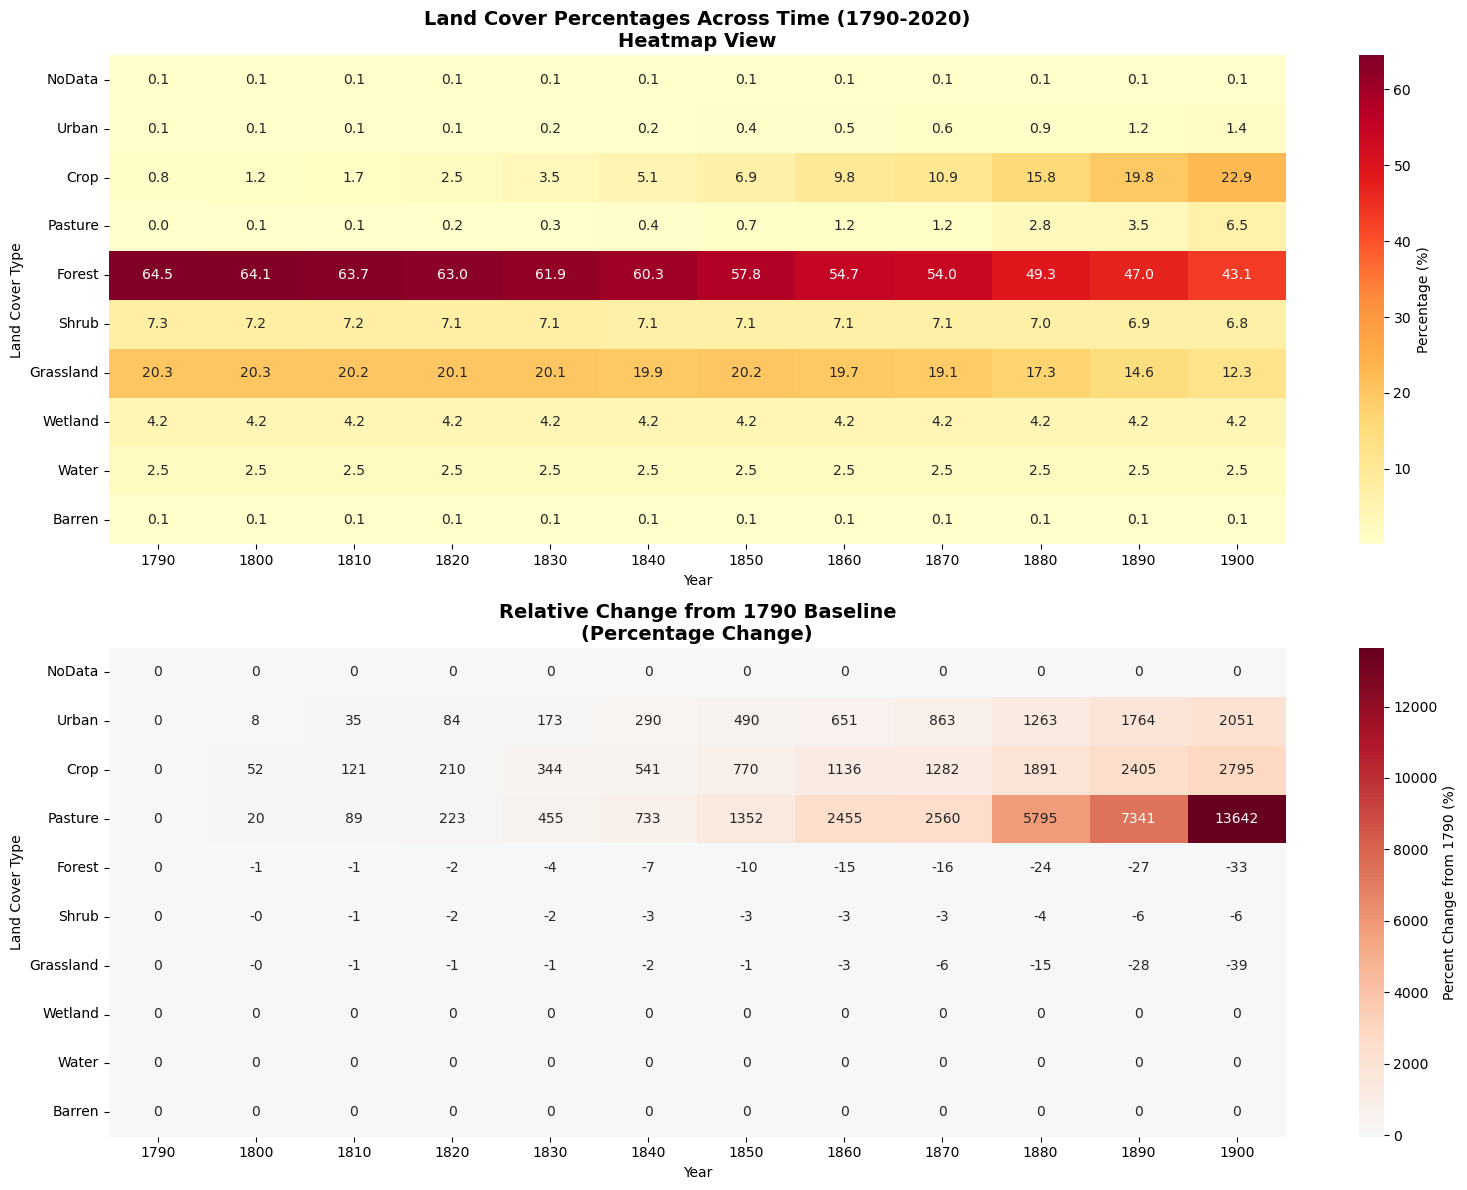


DECADE-BY-DECADE COMPARISON


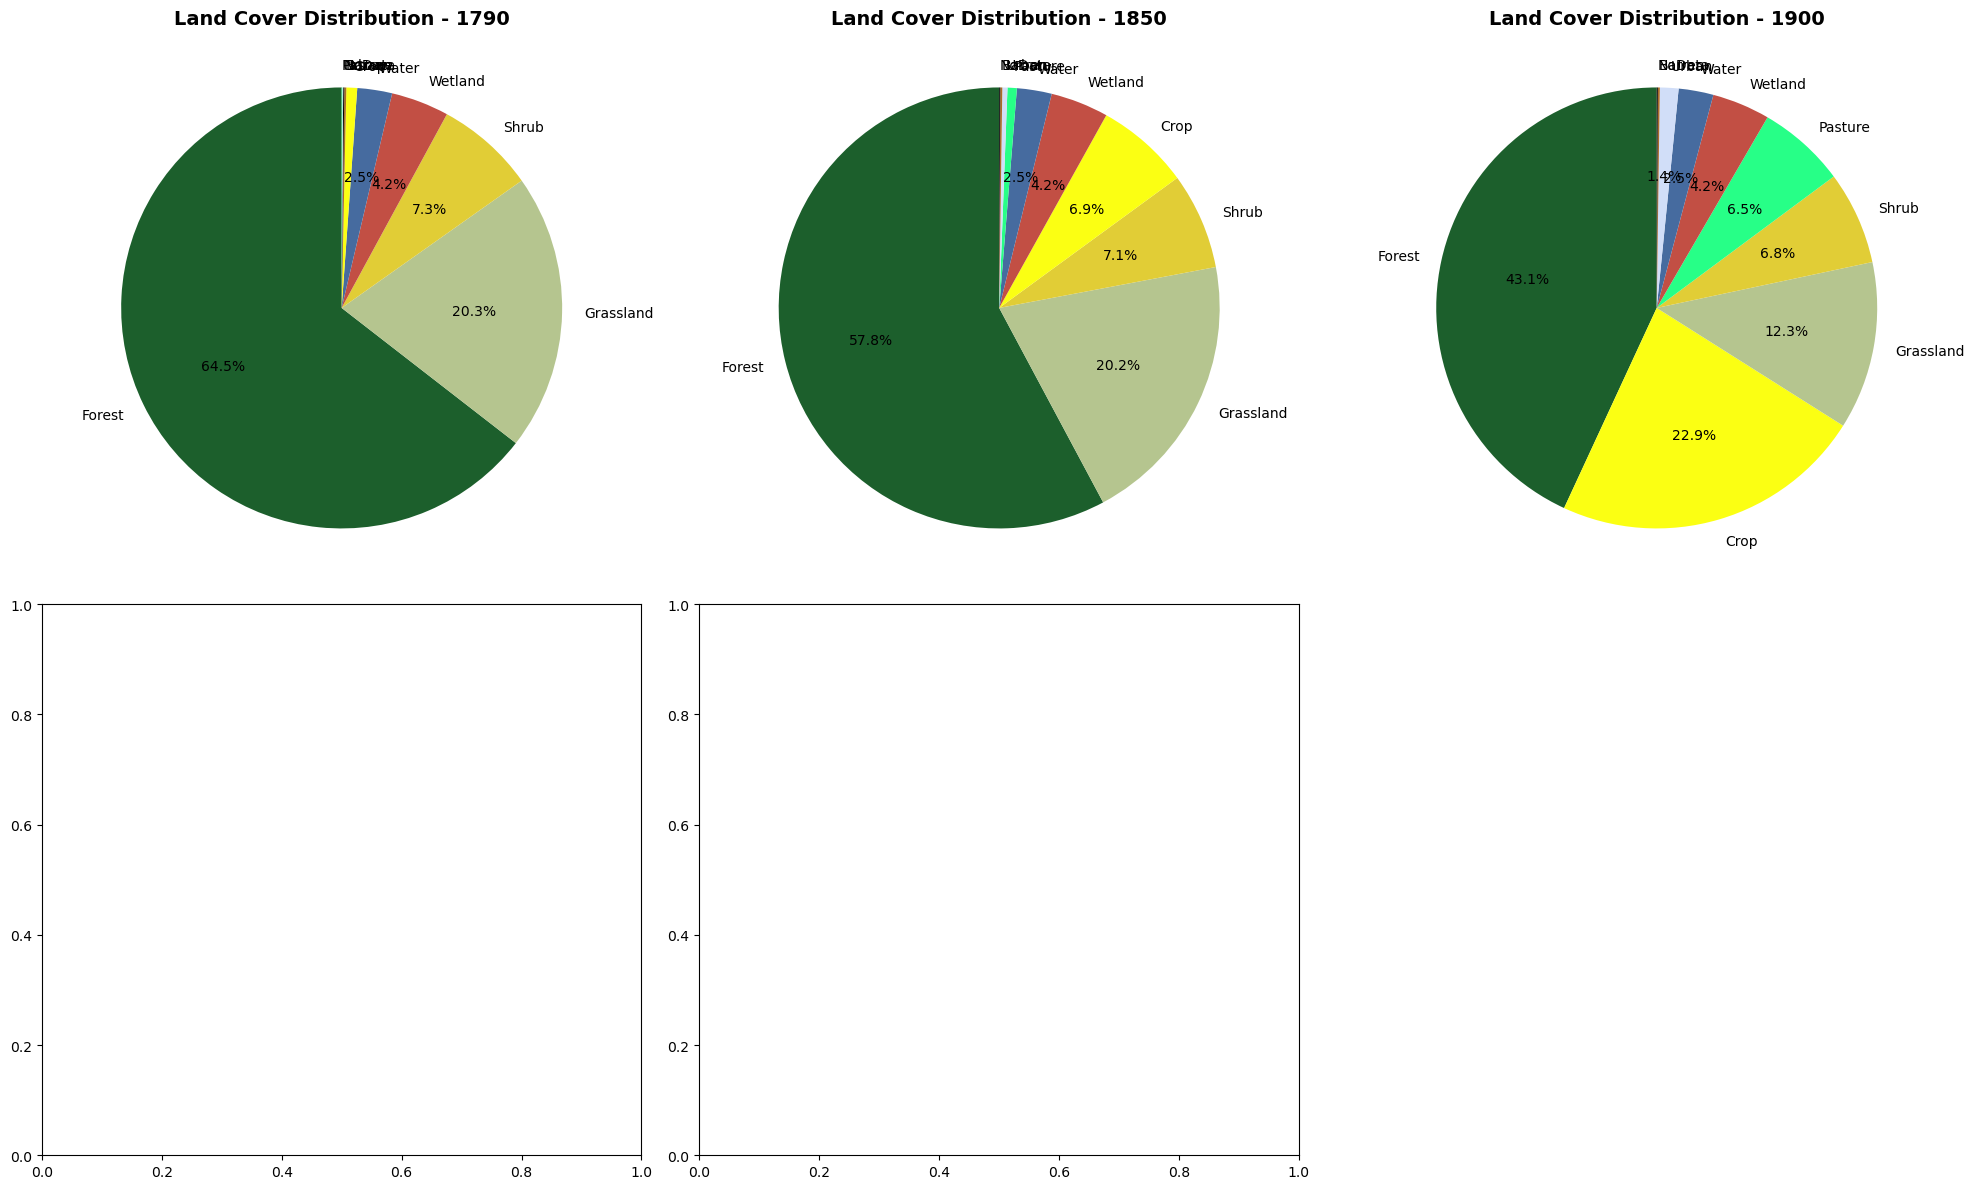


TRANSFORMATION METRICS (1790-2020):
----------------------------------------


KeyError: 2020

In [21]:
# --- ADDITIONAL TEMPORAL ANALYSIS ---

print("Creating additional temporal analysis visualizations...")

# 1. Create a heatmap showing land cover percentages across all years
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Heatmap of all land cover types over time
heatmap_data = yearly_averages.T  # Transpose so land cover types are rows, years are columns
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
            ax=ax1, cbar_kws={'label': 'Percentage (%)'})
ax1.set_title('Land Cover Percentages Across Time (1790-2020)\nHeatmap View', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Land Cover Type')

# 2. Create a normalized heatmap showing relative changes
# Calculate percentage change from 1790 baseline
baseline_year = 1790
change_from_baseline = yearly_averages.div(yearly_averages.loc[baseline_year], axis=1) * 100 - 100
change_from_baseline = change_from_baseline.T

sns.heatmap(change_from_baseline, annot=True, fmt='.0f', center=0, 
            cmap='RdBu_r', ax=ax2, cbar_kws={'label': 'Percent Change from 1790 (%)'})
ax2.set_title(f'Relative Change from {baseline_year} Baseline\n(Percentage Change)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Land Cover Type')

plt.tight_layout()
plt.show()

# 3. Create comparison panels for key decades
print("\n" + "="*60)
print("DECADE-BY-DECADE COMPARISON")
print("="*60)

key_decades = [1790, 1850, 1900]  # Key decades spanning the full range
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Changed to 2x3 for 5 subplots
axes = axes.flatten()

for i, year in enumerate(key_decades):
    ax = axes[i]
    year_data = yearly_averages.loc[year].sort_values(ascending=False)
    
    # Get colors for each land cover type
    colors = [land_cover_color_map.get(cover, '#cccccc') for cover in year_data.index]
    
    # Create pie chart
    wedges, texts, autotexts = ax.pie(year_data.values, labels=year_data.index, 
                                      colors=colors, autopct='%1.1f%%', startangle=90)
    
    ax.set_title(f'Land Cover Distribution - {year}', fontsize=14, fontweight='bold')
    
    # Only show percentages > 1% on the pie chart for clarity
    for autotext, value in zip(autotexts, year_data.values):
        if value < 1.0:
            autotext.set_text('')

# Hide the last empty subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# 4. Calculate and display transformation metrics
print("\nTRANSFORMATION METRICS (1790-2020):")
print("-" * 40)

# Calculate total area transformed
forest_loss = yearly_averages.loc[2020, 'Forest'] - yearly_averages.loc[1790, 'Forest']
crop_gain = yearly_averages.loc[2020, 'Crop'] - yearly_averages.loc[1790, 'Crop']
pasture_gain = yearly_averages.loc[2020, 'Pasture'] - yearly_averages.loc[1790, 'Pasture']
urban_gain = yearly_averages.loc[2020, 'Urban'] - yearly_averages.loc[1790, 'Urban']

print(f"Forest Loss: {abs(forest_loss):.1f} percentage points")
print(f"Agricultural Expansion:")
print(f"  - Crop Land: +{crop_gain:.1f} percentage points")
print(f"  - Pasture Land: +{pasture_gain:.1f} percentage points")
print(f"  - Total Agricultural: +{crop_gain + pasture_gain:.1f} percentage points")
print(f"Urban Expansion: +{urban_gain:.1f} percentage points")

# Calculate the rate of change per decade
decades = len(yearly_averages) - 1
forest_loss_per_decade = forest_loss / decades
agri_gain_per_decade = (crop_gain + pasture_gain) / decades
urban_gain_per_decade = urban_gain / decades

print(f"\nAverage Rate of Change per Decade:")
print(f"  - Forest Loss: {abs(forest_loss_per_decade):.1f} percentage points/decade")
print(f"  - Agricultural Expansion: +{agri_gain_per_decade:.1f} percentage points/decade")
print(f"  - Urban Expansion: +{urban_gain_per_decade:.1f} percentage points/decade")

# 5. Create a simple table showing the data for easy reference
print("\n" + "="*80)
print("YEARLY LAND COVER DATA TABLE (All Percentages)")
print("="*80)

# Format the yearly_averages for nice display
display_data = yearly_averages.round(1)
print(display_data.to_string())

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

# Store the yearly_averages for potential future use
print(f"\nNote: Yearly averages data is stored in 'yearly_averages' DataFrame")
print(f"      Access it with: yearly_averages")
print(f"      Individual year data still available in: county_cover_datasets[year]")

In [22]:
county_cover_datasets
county_cover_geodatasets

{1790:                                                geometry          GEO_ID STATE  \
 0     POLYGON ((881759.199 1114602.53, 881783.211 11...  0500000US01001    01   
 1     POLYGON ((820813.582 870207.64, 820796.977 870...  0500000US01003    01   
 2     POLYGON ((1022285.197 1028056.448, 1022305.898...  0500000US01005    01   
 3     POLYGON ((825530.89 1123561.709, 821922.415 11...  0500000US01007    01   
 4     POLYGON ((848383.878 1258023.836, 848735.502 1...  0500000US01009    01   
 ...                                                 ...             ...   ...   
 3104  POLYGON ((-1085521.057 2073715.214, -1095733.8...  0500000US56037    56   
 3105  POLYGON ((-1200815.828 2408199.842, -1200685.7...  0500000US56039    56   
 3106  POLYGON ((-1167348.582 2089921.069, -1168036.0...  0500000US56041    56   
 3107  POLYGON ((-887412.186 2385732.421, -888096.316...  0500000US56043    56   
 3108  POLYGON ((-645213.424 2335093.152, -645316.29 ...  0500000US56045    56   
 
      CO

In [26]:
def plot_county_cover_geodataset(year, county_cover_geodatasets, column=None, cmap='tab20', figsize=(16, 12)):
    """
    Plot the county land cover GeoDataFrame for a specified year.

    Parameters:
        year (int): Year to plot (must be a key in county_cover_geodatasets).
        county_cover_geodatasets (dict): Dictionary of year -> GeoDataFrame.
        column (str, optional): Column to color counties by (e.g., 'Forest_pct'). If None, just boundaries.
        cmap (str): Matplotlib colormap name.
        figsize (tuple): Figure size.

    Returns:
        None
    """
    import matplotlib.pyplot as plt

    if year not in county_cover_geodatasets:
        print(f"Year {year} not found in county_cover_geodatasets.")
        return

    gdf = county_cover_geodatasets[year]
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    if column and column in gdf.columns:
        gdf.plot(column=column, ax=ax, cmap=cmap, legend=True, edgecolor='black', linewidth=0.2)
        ax.set_title(f"County Land Cover ({column}) - {year}", fontsize=16)
    else:
        gdf.boundary.plot(ax=ax, color='black', linewidth=0.3)
        ax.set_title(f"County Boundaries - {year}", fontsize=16)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    plt.show()


In [40]:
def save_county_cover_data_h5(county_cover_datasets, county_cover_geodatasets, filename_prefix='county_cover'):
    """
    Save county_cover_datasets and county_cover_geodatasets as HDF5 (.h5) files.

    Parameters:
        county_cover_datasets (dict): Dictionary of year -> pandas DataFrame.
        county_cover_geodatasets (dict): Dictionary of year -> GeoPandas GeoDataFrame.
        filename_prefix (str): Prefix for output files.

    Returns:
        None
    """
    import pandas as pd

    # Save county_cover_datasets (pandas DataFrames)
    with pd.HDFStore(f'data_processed/node_feat/{filename_prefix}_datasets.h5', mode='w') as store:
        for year, df in county_cover_datasets.items():
            store.put(str(year), df)
    print(f"Saved county_cover_datasets to {filename_prefix}_datasets.h5")

    # Save county_cover_geodatasets (GeoDataFrames, without geometry)
    with pd.HDFStore(f'data_processed/node_feat/{filename_prefix}_geodatasets.h5', mode='w') as store:
        for year, gdf in county_cover_geodatasets.items():
            # Save only attribute data (geometry is not supported in HDF5)
            store.put(str(year), gdf.drop(columns='geometry'))
    print(f"Saved county_cover_geodatasets (attributes only) to {filename_prefix}_geodatasets.h5")

# Example usage:
# save_county_cover_data_h5(county_cover_datasets, county_cover_geodatasets)

In [41]:
save_county_cover_data_h5(county_cover_datasets, county_cover_geodatasets)

Saved county_cover_datasets to county_cover_datasets.h5
Saved county_cover_geodatasets (attributes only) to county_cover_geodatasets.h5


c:\Users\naoki\miniforge3\envs\gnn-env\Lib\site-packages\tables\path.py:146: NaturalNameWarning: object name is not a valid Python identifier: '1790'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\naoki\AppData\Local\Temp\ipykernel_13948\2664871572.py:18: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'GEOID'], dtype='object')]

  store.put(str(year), df)
c:\Users\naoki\miniforge3\envs\gnn-env\Lib\site-packages\tables\path.py:146: NaturalNameWarning: object name is not a valid Python identifier: '1800'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` wil